## Data Preparation and Data Cleaning

1. **Downsample the data**: For efficiency, We can reduce the size of the training data before We split it into train and validate sets. Originally, there are 500 training images and 100 testing images per class. We can downsample the 500 training images to 100 per class, that is 500 training images per superclass. Also, We can downsample the 100 testing images to 20 per class, that is 100 testing images per superclass. This can be done using random sampling techniques.

2. **Reshape the data**: The image data in the CIFAR-100 dataset is stored as 1D arrays. We want to reshape it into 3D arrays (32x32x3) for easier processing and analysis.

3. **Resize the data**: The image data in the CIFAR-100 dataset is 32x32. To be able to use transfer learning using common pretrained models, the image data has to be resized to a minimum of 75x75.

4. **Normalize the data**: The pixel values of the images are in the range [0, 255]. We want to normalize these values to the range [0, 1] for better performance of the machine learning models.

5. **Consider only the coarse labels**: For simplicity, We can consider only the 20 "coarse" labels (superclasses) rather than the 100 "fine" labels (classes) when We train multi-class image classifiers for this dataset. This means We would use `coarse_labels` instead of `fine_labels` in our code.

6. **One-hot encode the labels**: The labels are currently integers representing the class of each image. We want to one-hot encode these labels for multi-class classification tasks.

7. **Split the data**: The CIFAR-100 dataset comes with predefined train and test sets. We want to further split the train set into a validation set for tuning the hyperparameters of our models.

In [1]:
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# Load the data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Downsample the data
def downsample_data(data, labels, num_samples_per_class):
    downsampled_data = []
    downsampled_labels = []
    for i in range(20):  # 20 superclasses
        indices = np.where(labels == i)[0]
        downsampled_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        downsampled_data.append(data[downsampled_indices])
        downsampled_labels.append(labels[downsampled_indices])
    return np.concatenate(downsampled_data), np.concatenate(downsampled_labels)

# Load the data
metadata_path = '../data/cifar-100-python/meta'
metadata = unpickle(metadata_path)
data_train_path = '../data/cifar-100-python/train'
data_test_path = '../data/cifar-100-python/test'
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)

# Downsample the data
data_train, label_train = downsample_data(data_train_dict[b'data'], np.array(data_train_dict[b'coarse_labels']), 100)
data_test, label_test = downsample_data(data_test_dict[b'data'], np.array(data_test_dict[b'coarse_labels']), 20)

# Reshape the data
data_train = data_train.reshape((data_train.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
data_test = data_test.reshape((data_test.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)

# Resize the data to a minimum of 75x75
data_train = tf.image.resize(data_train, [75, 75])
data_test = tf.image.resize(data_test, [75, 75])

# Normalize the data
data_train = data_train.numpy().astype('float32') / 255
data_test = data_test.numpy().astype('float32') / 255

# One-hot encode the labels
label_train = to_categorical(label_train, 20)
label_test = to_categorical(label_test, 20)

# Split the data into train and validate sets
data_train, data_validate, label_train, label_validate = train_test_split(data_train, label_train, test_size=0.2, random_state=42)

# Save the cleaned and processed data
os.makedirs('../data/clean-cifar-100-python/train', exist_ok=True)
os.makedirs('../data/clean-cifar-100-python/validate', exist_ok=True)
os.makedirs('../data/clean-cifar-100-python/test', exist_ok=True)
np.save('../data/clean-cifar-100-python/train/data.npy', data_train)
np.save('../data/clean-cifar-100-python/train/labels.npy', label_train)
np.save('../data/clean-cifar-100-python/validate/data.npy', data_validate)
np.save('../data/clean-cifar-100-python/validate/labels.npy', label_validate)
np.save('../data/clean-cifar-100-python/test/data.npy', data_test)
np.save('../data/clean-cifar-100-python/test/labels.npy', label_test)

## EDA (Exploratory Data Analysis), Feature Importance Analysis

1. **Visualize the images**: Display some sample images from each class to get a sense of what the images look like.

2. **Class distribution**: Check the distribution of the classes in the train and test sets. If the classes are imbalanced, We need to take this into account when training our models.

3. **Feature importance**: In the context of image data, feature importance analysis might involve using techniques like occlusion sensitivity to understand which parts of the images are most important for the predictions of a trained model.

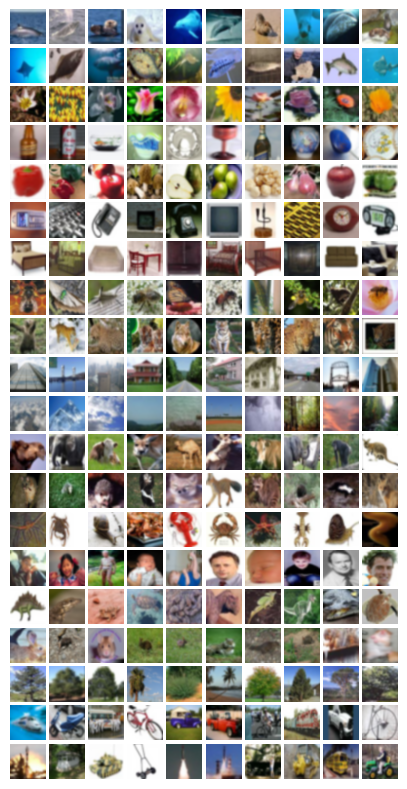

Class distribution: [82. 82. 78. 75. 79. 75. 82. 82. 84. 82. 85. 81. 84. 83. 79. 77. 72. 80.
 82. 76.]
Class distribution: [20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.
 20. 20.]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Visualize the images
def visualize_images(data, labels, num_images_per_class):
    fig, axs = plt.subplots(20, num_images_per_class, figsize=(5, 10))  # 20 superclasses
    for i in range(20):  # For each superclass
        indices = np.where(np.argmax(labels, axis=1) == i)[0]
        random_indices = np.random.choice(indices, num_images_per_class, replace=False)
        for j, image_index in enumerate(random_indices):
            image = data[image_index]
            axs[i, j].imshow(image, interpolation='bicubic')
            axs[i, j].axis('off')  # Hide axes
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Check the class distribution
def check_class_distribution(labels):
    class_distribution = np.sum(labels, axis=0)
    print("Class distribution:", class_distribution)

# Load the data
data_train, label_train = load_data('../data/clean-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-cifar-100-python/test')

# Visualize the images
visualize_images(data_train, label_train, 10)

# Check the class distribution
check_class_distribution(label_train)
check_class_distribution(label_test)

## Model Selection Process and Parameter Tuning

1. **Choose a model architecture**: For image classification tasks, convolutional neural networks (CNNs) are usually a good choice. We want to experiment with three different architectures (Xception, ResNet50, DenseNet121) to see which one works best for this dataset.

2. **Hyperparameter tuning**: Tune the hyperparameters of our model (learning rate, batch size, number of layers) to optimize its performance.

3. **Regularization**: To prevent overfitting, We want to use regularization techniques like dropout.

4. **Model training**: Train our model using the train set and monitor its performance on the validation set. We can use techniques like early stopping to prevent overfitting.

5. **Model evaluation**: Evaluate the performance of our model on the test set using appropriate metrics (e.g., accuracy, precision, recall, F1 score).

### A) Model Architecture: Xception

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Define the model
def make_model(learning_rate=0.01, size_inner=10, droprate=0.0):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)  # Use the same image size as in the original CIFAR-100 dataset
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(32, 32, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    vectors = Dropout(droprate)(vectors)  # Add dropout
    vectors = keras.layers.Dense(size_inner, activation='relu')(vectors)  # Adjust the size of inner layer
    outputs = keras.layers.Dense(20)(vectors)  # Use 20 superclasses
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Load the data
data_train, label_train = load_data('../data/clean-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-cifar-100-python/validate')

# Fine-tune the learning rate
best_val_accuracy = 0
best_lr = 0
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[lr] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_lr = lr

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.title('Validation Accuracy for the Learning Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Fine-tune the size_inner parameter
best_val_accuracy = 0
best_size = 0
scores = {}
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=best_lr, size_inner=size)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[size] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_size = size

for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.title('Validation Accuracy for the size_inner Parameter')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Fine-tune the dropout rate
best_val_accuracy = 0
best_droprate = 0
scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=droprate)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[droprate] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_droprate = droprate

for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.title('Validation Accuracy for the Dropout Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Save the best model using callbacks and checkpointing
model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=best_droprate)
checkpoint = ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(
    data_train,
    epochs=10,
    validation_data=(data_test, label_test),
    callbacks=[checkpoint]
)

### B) Model Architecture: ResNet50

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Define the model
def make_model(learning_rate=0.01, size_inner=10, droprate=0.0):
    base_model = ResNet50(  # Use ResNet50
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)  # Use the same image size as in the original CIFAR-100 dataset
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(32, 32, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    vectors = Dropout(droprate)(vectors)  # Add dropout
    vectors = keras.layers.Dense(size_inner, activation='relu')(vectors)  # Adjust the size of inner layer
    outputs = keras.layers.Dense(20)(vectors)  # Use 20 superclasses
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Load the data
data_train, label_train = load_data('../data/clean-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-cifar-100-python/validate')

# Fine-tune the learning rate
best_val_accuracy = 0
best_lr = 0
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[lr] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_lr = lr

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.title('Validation Accuracy for the Learning Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Fine-tune the size_inner parameter
best_val_accuracy = 0
best_size = 0
scores = {}
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=best_lr, size_inner=size)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[size] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_size = size

for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.title('Validation Accuracy for the size_inner Parameter')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Fine-tune the dropout rate
best_val_accuracy = 0
best_droprate = 0
scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=droprate)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[droprate] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_droprate = droprate

for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.title('Validation Accuracy for the Dropout Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Save the best model using callbacks and checkpointing
model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=best_droprate)
checkpoint = ModelCheckpoint(
    'resnet50_v1_{epoch:02d}_{val_accuracy:.3f}.h5',  # Change the filename to reflect the use of ResNet50
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(
    data_train,
    epochs=10,
    validation_data=(data_test, label_test),
    callbacks=[checkpoint]
)

### C) Model Architecture: DenseNet121

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Define the model
def make_model(learning_rate=0.01, size_inner=10, droprate=0.0):
    base_model = DenseNet121(  # Use DenseNet121 instead of ResNet50
        weights='imagenet',
        include_top=False,
        input_shape=(32, 32, 3)  # Use the same image size as in the original CIFAR-100 dataset
    )
    base_model.trainable = False
    inputs = keras.Input(shape=(32, 32, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    vectors = Dropout(droprate)(vectors)  # Add dropout
    vectors = keras.layers.Dense(size_inner, activation='relu')(vectors)  # Adjust the size of inner layer
    outputs = keras.layers.Dense(20)(vectors)  # Use 20 superclasses
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    return model

# Load the data
data_train, label_train = load_data('../data/clean-cifar-100-python/train')
data_test, label_test = load_data('../data/clean-cifar-100-python/validate')

# Fine-tune the learning rate
best_val_accuracy = 0
best_lr = 0
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[lr] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_lr = lr

for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.title('Validation Accuracy for the Learning Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Fine-tune the size_inner parameter
best_val_accuracy = 0
best_size = 0
scores = {}
for size in [10, 100, 1000]:
    print(size)
    model = make_model(learning_rate=best_lr, size_inner=size)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[size] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_size = size

for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.title('Validation Accuracy for the size_inner Parameter')
plt.xticks(np.arange(10))
plt.legend()
plt.show()
        
# Fine-tune the dropout rate
best_val_accuracy = 0
best_droprate = 0
scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=droprate)
    history = model.fit(data_train, label_train, epochs=10, validation_data=(data_test, label_test))
    scores[droprate] = history.history
    if max(history.history['val_accuracy']) > best_val_accuracy:
        best_val_accuracy = max(history.history['val_accuracy'])
        best_droprate = droprate

for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.title('Validation Accuracy for the Dropout Rate')
plt.xticks(np.arange(10))
plt.legend()
plt.show()

# Save the best model using callbacks and checkpointing
model = make_model(learning_rate=best_lr, size_inner=best_size, droprate=best_droprate)
checkpoint = ModelCheckpoint(
    'densenet121_v1_{epoch:02d}_{val_accuracy:.3f}.h5',  # Change the filename to reflect the use of DenseNet121
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = model.fit(
    data_train,
    epochs=10,
    validation_data=(data_test, label_test),
    callbacks=[checkpoint]
)

### D) Best Model Comparison

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the data
def load_data(folder):
    data = np.load(os.path.join(folder, 'data.npy'))
    labels = np.load(os.path.join(folder, 'labels.npy'))
    return data, labels

# Load the test data
data_test, label_test = load_data('../data/clean-cifar-100-python/test')

# Define the model names
model_names = ['xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5', 
               'resnet50_v1_{epoch:02d}_{val_accuracy:.3f}.h5', 
               'densenet121_v1_{epoch:02d}_{val_accuracy:.3f}.h5']

# Initialize a dictionary to store the metrics
metrics = {}

# For each model
for model_name in model_names:
    # Load the model
    model = load_model(model_name)
    # Evaluate the model
    loss, accuracy = model.evaluate(data_test, label_test, verbose=0)
    # Predict the classes
    y_pred = model.predict(data_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(label_test, axis=1)
    # Calculate precision, recall, and F1 score
    classification_metrics = classification_report(y_true_classes, y_pred_classes, output_dict=True)
    precision = classification_metrics['weighted avg']['precision']
    recall = classification_metrics['weighted avg']['recall']
    f1_score = classification_metrics['weighted avg']['f1-score']
    # Store the metrics
    metrics[model_name] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}

# Plot the metrics
plt.figure(figsize=(10, 6))
for model_name, model_metrics in metrics.items():
    plt.plot(list(model_metrics.values()), label=model_name)
plt.xticks(np.arange(4), ['accuracy', 'precision', 'recall', 'f1_score'])
plt.legend()
plt.show()

### E) Final Model Selection

In [ ]:
#TODO